---
format: 
  html:
    toc: true
    number-sections: true
    code-fold: true
execute:
  echo: true
---

# Gather and Explore Additional Prediction Data

Similar to the previous step, this section compiles the identical independent features hypothesized to correlate with trash complaint counts for year 2023-24. Note that data from this step will be used for prediction, using best-fit model trained upon 2022-2023 data. Thus the output dataframe at the end of this section lacks the independent variable `Complaint Count`.

## Set Up

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import osmnx as ox
import cenpy
import pygris

import seaborn as sns
!pip install hvplot
import holoviews as hv
hv.extension('bokeh') 
from datashader.colors import viridis
import hvplot.pandas

from shapely.wkt import loads
from shapely.geometry import MultiLineString
from shapely.ops import nearest_points

from datetime import datetime
import matplotlib.pyplot as plt

!pip install meteostat
from meteostat import Point, Daily, Stations

!pip install holidays
import holidays

# Show all columns in dataframes
pd.options.display.max_columns = 999

# Hide warnings due to issue in shapely package 
# See: https://github.com/shapely/shapely/issues/1345
np.seterr(invalid="ignore");

## Load DSNY Boundary and Complaint Data (2022 and 2023)

### Load DSNY Boundary

In [2]:
DSNY_boundary = gpd.read_file('data/1_DSNY_boundary_processed.geojson')

# Reproject to state plane
DSNY_boundary = DSNY_boundary.to_crs(epsg=2263)

### Load Complaint Data

In [3]:
# Load 2023 data
complaints_23 = pd.read_parquet('data/1_complaints_DSNY_full_2023.parquet')

In [4]:
# Convert date to the right format
complaints_23['Created Date'] = pd.to_datetime(complaints_23['Created Date'], errors='coerce')

Since 2024 Complaint Counts are to be predicted rather than existant, a full DSNY unit-date panel is created to hold all forecasted features (count of litter baskets and traffic) for 2024.

In addition, because 2024 has 366 days compared to 2023 with 365 days, to ensure all lagged data match, the date 2024-02-29 is removed from the panel.

In [5]:
# Create 2024 full DSNY-date panel
date_range = pd.date_range(start="2024-01-01", end="2024-12-31")

# Get unique DSNY units
unique_IDs = DSNY_boundary['DSNY_ID'].unique()

# Create a dataframe with all DSNY unit-date combinations
full_panel = pd.MultiIndex.from_product(
    [unique_IDs, date_range], names=['DSNY_ID', 'Created Date']
).to_frame(index=False)

complaints_24 = full_panel

In [6]:
# removing Feb 29th, 2024
complaints_24 = complaints_24[complaints_24['Created Date'] != '2024-02-29']

## Lagged Data Gathering

### Gather 2023 ACS 5-year data

#### Data Gathering

In [7]:
variables = ["NAME",
             "B19013_001E", #median hh income
             "B01003_001E", #total pop
             "B03002_003E", #white alone
             "B03002_012E", #hispanic-latino total
             "B06012_002E", #poverty rate
             "B25010_001E" #average hh size
            ]

acs = cenpy.remote.APIConnection("ACSDT5Y2023")

NYC_county_code = ["005", "047", "061", "081", "085"]
NYC_code = "36"
NYC_county_string = ",".join(NYC_county_code)

acs_vars = acs.query(
    cols=variables,
    geo_unit="tract:*",
    geo_filter={"state": NYC_code, "county": NYC_county_string},
)

# Rename columns
acs_vars.rename(columns={
    "B19013_001E": "Med_HH_Inc", 
    "B01003_001E": "Tot_Pop", 
    "B03002_003E": "White_Alone",
    "B03002_012E": "Hispanic_Latino",
    "B06012_002E": "Poverty_Pop",
    "B25010_001E": "Avg_HH_Size"
}, inplace=True)

# Convert to Numeric
exclude_cols= ['NAME', 'tract', 'state', 'county']
acs_vars.loc[:, ~acs_vars.columns.isin(exclude_cols)] = (
    acs_vars.loc[:, ~acs_vars.columns.isin(exclude_cols)]
    .apply(pd.to_numeric, errors='coerce')
)

# Remove invalid results
acs_vars = acs_vars[
    (acs_vars['Med_HH_Inc'] != -666666666) & 
    (acs_vars['Avg_HH_Size'] != -666666666)
]
acs_vars = acs_vars.reset_index(drop=True)

# calculate race/ethnicity share
acs_vars['Pct_Non_White'] = (1 - (acs_vars['White_Alone'] / acs_vars['Tot_Pop'])) * 100
acs_vars['Pct_Hispanic'] = (acs_vars['Hispanic_Latino'] / acs_vars['Tot_Pop']) * 100
acs_vars['Poverty_Rate'] = (acs_vars['Poverty_Pop'] / acs_vars['Tot_Pop']) * 100

# Modify GEOID of the acs_vars data frame
acs_vars["GEOID"] = (
    acs_vars["state"].astype(str).str.zfill(2) +  
    acs_vars["county"].astype(str).str.zfill(3) +
    acs_vars["tract"].astype(str).str.zfill(6)
)

# select necessary columns
acs_vars = acs_vars[["GEOID", "Med_HH_Inc", "Pct_Non_White", "Pct_Hispanic", "Poverty_Rate", "Avg_HH_Size"]]

# Get NYC tracts boundaries
NYC_tracts = pygris.tracts(state="36", county=NYC_county_code, year=2022)

# Merge info with tract boundaries
acs_vars_tracts= acs_vars.merge(NYC_tracts, on="GEOID", how="left")

# select necessary columns
acs_vars_tracts = acs_vars_tracts[["GEOID", "Med_HH_Inc", "Pct_Non_White", "Pct_Hispanic", "Poverty_Rate", "Avg_HH_Size","geometry"]]

#### Join ACS Variables with DSNY Boundaries

In [8]:
# Calculate centroids of DSNY_boundary
DSNY_boundary['centroid'] = DSNY_boundary.geometry.centroid
DSNY_centroids = DSNY_boundary.set_geometry('centroid')

DSNY_boundary = DSNY_boundary.drop(columns=['centroid'])

# Ensure CRS matches between the two datasets
acs_vars_tracts = gpd.GeoDataFrame(acs_vars_tracts, geometry=acs_vars_tracts['geometry'], crs="EPSG:4326")
acs_vars_tracts = acs_vars_tracts.to_crs(DSNY_boundary.crs)

# Perform spatial join to match centroids with ACS tract data
DSNY_boundary_with_acs = gpd.sjoin(DSNY_centroids, acs_vars_tracts, how="left", predicate="intersects").drop(columns=['index_right'])

DSNY_boundary_with_acs = DSNY_boundary_with_acs.drop(columns=['centroid'])

#### Join ACS Variables with Complaints Data by District

In [9]:
complaints_23 = (complaints_23.merge(DSNY_boundary_with_acs, on="DSNY_ID", how="left"))

### Gather 2023 NYC Restaurants Violation Data

Note: the data loaded is pre-processed to filter out only violations related to trash.

source: [https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j/about_data]

#### Data Gathering

In [10]:
restaurant_violations = pd.read_csv("data/sanitation_related_restaurant_inspections.csv")

#### Join Restaurant Violations with DSNY Boundaries

In [11]:
# Convert restaurant violations data to a GeoDataFrame
restaurant_violations = restaurant_violations[['CAMIS', 'INSPECTION DATE', 'Latitude', 'Longitude']]

restaurant_violations = gpd.GeoDataFrame(
  restaurant_violations, geometry=gpd.points_from_xy(restaurant_violations.Longitude, restaurant_violations.Latitude), crs="EPSG:4326"
  )

restaurant_violations = restaurant_violations.to_crs(DSNY_boundary.crs)

# Perform spatial join - identify which DSNY district the restaurant is associated with 
DSNY_boundary_with_rv = gpd.sjoin(restaurant_violations, DSNY_boundary, how="right", predicate="within")

# Group violation inspections by district and date
DSNY_boundary_with_rv = (
    DSNY_boundary_with_rv.groupby(['DSNY_ID', 'INSPECTION DATE'])['CAMIS']
    .nunique()
    .reset_index()
)

DSNY_boundary_with_rv.rename(columns={'CAMIS': 'Restaurant Inspection Count'}, inplace=True)

DSNY_boundary_with_rv.rename(columns={"INSPECTION DATE": "Created Date"}, inplace=True)

#### Join Restaurant Violations with Complaints Data by District and Date

In [12]:
# Join with complaints data 2023
DSNY_boundary_with_rv['Created Date'] = pd.to_datetime(DSNY_boundary_with_rv['Created Date'], format='%m/%d/%Y', errors='coerce')

# Join with the time series dataframe
complaints_23 = complaints_23.merge(
    DSNY_boundary_with_rv,
    on=["Created Date", "DSNY_ID"],  
    how="left"                       
)

### Gather 2023 NYC Other 311 Data

#### Data Gathering

In [13]:
# Derelict Vehicles
derelict_vehicles = pd.read_parquet("data/derelict_vehicles.parquet")

# Graffiti
graffiti = pd.read_parquet("data/graffiti.parquet")

#### Join Other 311 Data with DSNY Boundaries

In [14]:
# Join derelict vehicles
    # Convert derelict vehicles data to a GeoDataFrame
derelict_vehicles = derelict_vehicles[['Unique Key', 'Created Date', 'Latitude', 'Longitude']]

derelict_vehicles = gpd.GeoDataFrame(
  derelict_vehicles, geometry=gpd.points_from_xy(derelict_vehicles.Longitude, derelict_vehicles.Latitude), crs="EPSG:4326"
  )

derelict_vehicles = derelict_vehicles.to_crs(DSNY_boundary.crs)

    # Perform spatial join
DSNY_boundary_with_dv = gpd.sjoin(derelict_vehicles, DSNY_boundary, how="right", predicate="within")

    # Group derelict vehicles by district and date
DSNY_boundary_with_dv = (
    DSNY_boundary_with_dv.groupby(['DSNY_ID', 'Created Date'])['Unique Key']
    .nunique()
    .reset_index()
)

DSNY_boundary_with_dv.rename(columns={'Unique Key': 'Derelict Vehicle Count'}, inplace=True)


# Join Graffiti
    # Convert graffiti data to a GeoDataFrame
graffiti = graffiti[['Unique Key', 'Created Date', 'Latitude', 'Longitude']]

graffiti = gpd.GeoDataFrame(
  graffiti, geometry=gpd.points_from_xy(graffiti.Longitude, graffiti.Latitude), crs="EPSG:4326"
  )

graffiti = graffiti.to_crs(DSNY_boundary.crs)

    # Perform spatial join
DSNY_boundary_with_g = gpd.sjoin(graffiti, DSNY_boundary, how="right", predicate="within")

    # Group graffiti by district and date
DSNY_boundary_with_g = (
    DSNY_boundary_with_g.groupby(['DSNY_ID', 'Created Date'])['Unique Key']
    .nunique()
    .reset_index()
)

DSNY_boundary_with_g.rename(columns={'Unique Key': 'Graffiti Count'}, inplace=True)

#### Join Other 311 Data with Complaints Data by District and Date

In [15]:
# Make sure dates are in datetime format
DSNY_boundary_with_dv['Created Date'] = pd.to_datetime(DSNY_boundary_with_dv['Created Date'], errors='coerce')
DSNY_boundary_with_g['Created Date'] = pd.to_datetime(DSNY_boundary_with_g['Created Date'], errors='coerce')

# Join derelict vehicle records with the time series dataframe
complaints_23 = complaints_23.merge(
    DSNY_boundary_with_dv,
    on=["Created Date", "DSNY_ID"],  
    how="left"                       
)

# Join graffiti records with the time series dataframe
complaints_23 = complaints_23.merge(
    DSNY_boundary_with_g,
    on=["Created Date", "DSNY_ID"],  
    how="left"                       
)

### Gather 2023 Weather Data

#### Data Gathering

In [16]:
# Define time range for weather data
weather_start = datetime(2023, 1, 1)
weather_end = datetime(2023, 12, 31)

# Location weather data station
stations = Stations()
stations = stations.nearby(40.7128, -74.0060)
station = stations.fetch()

In [17]:
# Location weather data station
stations = Stations()
stations = stations.nearby(40.7128, -74.0060)
station = stations.fetch()

# Pick station
JFK = station[station['name'] == "John F. Kennedy Airport"]

# Gather data
weather_data = Daily(JFK, weather_start, weather_end)
weather_data = weather_data.fetch()

# Reset the index to make 'time' a regular column
weather_data = weather_data.reset_index()

# Convert 'time' to datetime format
weather_data['time'] = pd.to_datetime(weather_data['time'], errors='coerce')

# Trim temperature, precipitation and snow data
weather_cols = ['time', 'tavg', 'prcp', 'snow']
weather_data = weather_data.loc[:, weather_data.columns.isin(weather_cols)]

# Rename columns
weather_data.rename(columns={
    "tavg": "avg_temp",
    "prcp": "precipitation"
}, inplace=True)

#### Join Weather Data with Complaints Data by Date

In [18]:
complaints_23 = complaints_23.merge(
    weather_data,
    left_on="Created Date",  
    right_on="time",        
    how="left"             
)

complaints_23 = complaints_23.drop(columns=['time'])

In [19]:
complaints_23

,DSNY_ID,Created Date,Complaint Count,geometry,GEOID,Med_HH_Inc,Pct_Non_White,Pct_Hispanic,Poverty_Rate,Avg_HH_Size,Restaurant Inspection Count,Derelict Vehicle Count,Graffiti Count,avg_temp,precipitation,snow
0,BKN011_A,2023-01-01,0.0,"MULTIPOLYGON (((995020.254 205025.197, 995260....",36047056100,160810.0,35.139665,17.234637,8.296089,2.05,NaN,NaN,NaN,9.8,0.0,0.0
1,BKN011_A,2023-01-02,0.0,"MULTIPOLYGON (((995020.254 205025.197, 995260....",36047056100,160810.0,35.139665,17.234637,8.296089,2.05,NaN,1.0,NaN,7.8,0.5,0.0
2,BKN011_A,2023-01-03,0.0,"MULTIPOLYGON (((995020.254 205025.197, 995260....",36047056100,160810.0,35.139665,17.234637,8.296089,2.05,NaN,NaN,NaN,9.0,9.1,0.0
3,BKN011_A,2023-01-04,0.0,"MULTIPOLYGON (((995020.254 205025.197, 995260....",36047056100,160810.0,35.139665,17.234637,8.296089,2.05,NaN,NaN,NaN,10.6,0.3,0.0
4,BKN011_A,2023-01-05,0.0,"MULTIPOLYGON (((995020.254 205025.197, 995260....",36047056100,160810.0,35.139665,17.234637,8.296089,2.05,NaN,1.0,NaN,9.6,1.3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222645,SI038_E,2023-12-27,1.0,"MULTIPOLYGON (((921213.717 128503.472, 921135....",36085024800,148914.0,27.681733,23.328473,4.019996,2.8,NaN,NaN,NaN,6.2,4.8,0.0
222646,SI038_E,2023-12-28,0.0,"MULTIPOLYGON (((921213.717 128503.472, 921135....",36085024800,148914.0,27.681733,23.328473,4.019996,2.8,NaN,NaN,NaN,10.2,39.4,0.0
222647,SI038_E,2023-12-29,0.0,"MULTIPOLYGON (((921213.717 128503.472, 921135....",36085024800,148914.0,27.681733,23.328473,4.019996,2.8,NaN,NaN,NaN,9.3,0.5,NaN
222648,SI038_E,2023-12-30,0.0,"MULTIPOLYGON (((921213.717 128503.472, 921135....",36085024800,148914.0,27.681733,23.328473,4.019996,2.8,NaN,NaN,NaN,6.6,0.0,NaN


## Non-Lagged Data Gathering

### Gather Litter Basket Data

#### Data Gathering

In [20]:
litter_basket = pd.read_csv("data/DSNY_Litter_Basket_Inventory.csv")

#### Join Litter Basket Data with DSNY Boundaries

In [21]:
litter_basket['point'] = litter_basket['point'].apply(loads)

litter_basket_gdf = gpd.GeoDataFrame(
    litter_basket, 
    geometry=litter_basket['point'],
    crs="EPSG:4326"
)

litter_basket_gdf = litter_basket_gdf.to_crs(DSNY_boundary.crs)

DSNY_boundary_with_baskets = gpd.sjoin(litter_basket_gdf, DSNY_boundary, how="right", predicate="within")

# count number of baskets by DSNY units
DSNY_boundary_with_baskets = (
    DSNY_boundary_with_baskets.groupby(['DSNY_ID'])['BASKETID']
    .nunique()
    .reset_index()
)

DSNY_boundary_with_baskets.rename(columns={'BASKETID': 'Basket Count'}, inplace=True)

#### Join Litter Basket Data with Complaints Data by District

In [22]:
complaints_24 = (complaints_24.merge(DSNY_boundary_with_baskets, on="DSNY_ID", how="left"))

### Gather Traffic Data

#### Data Gathering

In [23]:
# Load street network in New York using OpenStreetMap API
place_name = "New York, USA"
G = ox.graph_from_place(place_name, network_type="drive")

# Convert street network graph to GeoDataFrame
edges = ox.graph_to_gdfs(G, nodes=False)
edges = edges.dropna(subset=['name', 'length', 'geometry'])

# Convert the list of street names to a single string
edges['name'] = edges['name'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

# Merge edge geometry with the same name
edges_grouped = edges.groupby('name').agg({
    'geometry': lambda x: MultiLineString([geom for geom in x]),
    'length': 'sum'
}).reset_index()

# Convert the edge grouped data to GeoDataFrame
edges_grouped = gpd.GeoDataFrame(edges_grouped, geometry='geometry')

In [24]:
# Load traffic count data
traffic_count = pd.read_csv("./data/Traffic_Volume_Counts.csv")

# Calculate total traffic count for each segment per count date
retain_columns = ['ID', 'SegmentID', 'Roadway Name', 'From', 'To', 'Direction', 'Date']
sum_columns = [col for col in traffic_count.columns if col not in retain_columns]
traffic_count['count'] = traffic_count[sum_columns].sum(axis=1)
traffic_count = traffic_count.drop(columns=sum_columns)

# calculate the average daily traffic on each road
traffic_count_grouped = traffic_count.groupby('Roadway Name').agg({ 'count': 'mean' }).reset_index()

In [25]:
traffic_count_grouped['Roadway Name'] = traffic_count_grouped['Roadway Name'].str.lower()
edges_grouped['name'] = edges_grouped['name'].str.lower()

# merge the average daily traffic volume to street network
traffic_merged = pd.merge(
    traffic_count_grouped,
    edges_grouped,
    left_on='Roadway Name',  
    right_on='name',        
    how='inner'             
)

traffic_merged = traffic_merged.drop(columns=['name'])

#### Join Traffic Data with DSNY Boundaries

In [26]:
# Convert traffic_merged to a GeoDataFrame object with correct state plane projection
traffic_merged = gpd.GeoDataFrame(traffic_merged, geometry='geometry')
traffic_merged = traffic_merged.set_crs("EPSG:4326") 
traffic_merged = traffic_merged.to_crs(DSNY_boundary.crs)

# Perform a spatial join to assign roads to DSNY units
DSNY_boundary_with_traffic = gpd.sjoin(traffic_merged, DSNY_boundary, how="inner", predicate="intersects")

In [27]:
DSNY_boundary_with_traffic = DSNY_boundary_with_traffic.groupby('DSNY_ID').agg({ 'count': 'mean' }).reset_index()

#### Join Traffic Data with Complaints Data by District

In [28]:
complaints_24 = (complaints_24.merge(DSNY_boundary_with_traffic, on="DSNY_ID", how="left"))

complaints_24.rename(columns={'count': 'Traffic Count'}, inplace=True)

### Add a Holiday Column

In [29]:
complaints_24['Holiday'] = complaints_24['Created Date'].isin(holidays.US())

### Add a Day of the Week Column

In [30]:
complaints_24['Day of Week'] = complaints_24['Created Date'].dt.day_name()

### Add a Week Column

In [31]:
complaints_24['Week'] = complaints_24['Created Date'].dt.isocalendar().week

In [32]:
complaints_24

,DSNY_ID,Created Date,Basket Count,Traffic Count,Holiday,Day of Week,Week
0,QE141_E,2024-01-01,70,10146.444444,False,Monday,1
1,QE141_E,2024-01-02,70,10146.444444,False,Tuesday,1
2,QE141_E,2024-01-03,70,10146.444444,False,Wednesday,1
3,QE141_E,2024-01-04,70,10146.444444,False,Thursday,1
4,QE141_E,2024-01-05,70,10146.444444,False,Friday,1
...,...,...,...,...,...,...,...
222645,MN073_A,2024-12-27,84,14356.583059,False,Friday,52
222646,MN073_A,2024-12-28,84,14356.583059,False,Saturday,52
222647,MN073_A,2024-12-29,84,14356.583059,False,Sunday,52
222648,MN073_A,2024-12-30,84,14356.583059,False,Monday,1


## Merge 2023 and 2024 Complaint Data

In [33]:
# Transform 2023 data Created Date to Match Date
complaints_23['Match Date'] = complaints_23['Created Date'] + pd.DateOffset(years=1)
complaints_23 = complaints_23.drop(columns=['Created Date'])

# Rename Count column in 2023 data
complaints_23.rename(columns={"Complaint Count": "Complaint Count Lag"}, inplace=True)

In [34]:
# Merge the two dataset 
DSNY_pred_final = complaints_23.merge(
    complaints_24,
    left_on=['DSNY_ID', 'Match Date'],
    right_on=['DSNY_ID', 'Created Date'],
    how='right'
)

DSNY_pred_final = DSNY_pred_final.drop(columns=['Match Date', 'GEOID'])
DSNY_pred_final.rename(columns={'Created Date': 'Date'}, inplace=True)

DSNY_pred_final.head()

,DSNY_ID,Complaint Count Lag,geometry,Med_HH_Inc,Pct_Non_White,Pct_Hispanic,Poverty_Rate,Avg_HH_Size,Restaurant Inspection Count,Derelict Vehicle Count,Graffiti Count,avg_temp,precipitation,snow,Date,Basket Count,Traffic Count,Holiday,Day of Week,Week
0,QE141_E,0.0,"MULTIPOLYGON (((1027896.113 148511.306, 102775...",102324.0,25.280899,17.953102,12.066439,2.42,NaN,NaN,NaN,9.8,0.0,0.0,2024-01-01,70,10146.444444,False,Monday,1
1,QE141_E,0.0,"MULTIPOLYGON (((1027896.113 148511.306, 102775...",102324.0,25.280899,17.953102,12.066439,2.42,NaN,NaN,NaN,7.8,0.5,0.0,2024-01-02,70,10146.444444,False,Tuesday,1
2,QE141_E,2.0,"MULTIPOLYGON (((1027896.113 148511.306, 102775...",102324.0,25.280899,17.953102,12.066439,2.42,NaN,NaN,NaN,9.0,9.1,0.0,2024-01-03,70,10146.444444,False,Wednesday,1
3,QE141_E,1.0,"MULTIPOLYGON (((1027896.113 148511.306, 102775...",102324.0,25.280899,17.953102,12.066439,2.42,NaN,NaN,NaN,10.6,0.3,0.0,2024-01-04,70,10146.444444,False,Thursday,1
4,QE141_E,0.0,"MULTIPOLYGON (((1027896.113 148511.306, 102775...",102324.0,25.280899,17.953102,12.066439,2.42,NaN,NaN,NaN,9.6,1.3,0.0,2024-01-05,70,10146.444444,False,Friday,1


### Create a Mapping Master Dataframe

In [35]:
DSNY_pred_final_grouped = DSNY_pred_final.groupby('DSNY_ID').agg({
    'Complaint Count Lag': 'sum',         
    'Pct_Non_White': 'mean',    
    'Pct_Hispanic': 'mean',  
    'Poverty_Rate': 'mean',  
    'Avg_HH_Size': 'mean',  
    'Restaurant Inspection Count': 'sum',
    'Derelict Vehicle Count':'sum',
    'Basket Count': 'mean'      
}).reset_index()

# Rename columns
DSNY_pred_final_grouped.rename(columns={
    "Complaint Count Lag": "2023 Annual Total of Complaint Count",
    "Pct_Non_White": "2024 Share of Non-White Population",
    "Pct_Hispanic": "2024 Share of Hispanic-Latino Population",
    "Poverty_Rate": "2024 Poverty Rate", 
    "Avg_HH_Size": "2024 Average Household Size",
    "Restaurant Inspection Count": "2024 Annual Total of Restaurant Inspection Count",
    "Derelict Vehicle Count": "2024 Annual Total of Derelict Vehicle Count",
    "Basket Count": "2024 Annual Total of Basket Count"
}, inplace=True)

In [36]:
DSNY_pred_final_grouped = DSNY_pred_final_grouped.merge(DSNY_boundary, on="DSNY_ID", how="right")
DSNY_pred_final_grouped = gpd.GeoDataFrame(DSNY_pred_final_grouped, geometry=DSNY_pred_final_grouped['geometry'], crs="EPSG:4326")
DSNY_pred_final_grouped = DSNY_pred_final_grouped.to_crs(DSNY_boundary.crs)

DSNY_pred_final_grouped.head()

,DSNY_ID,2023 Annual Total of Complaint Count,2024 Share of Non-White Population,2024 Share of Hispanic-Latino Population,2024 Poverty Rate,2024 Average Household Size,2024 Annual Total of Restaurant Inspection Count,2024 Annual Total of Derelict Vehicle Count,2024 Annual Total of Basket Count,geometry
0,QE141_E,37.0,25.280899,17.953102,12.066439,2.42,4.0,15.0,70.0,"MULTIPOLYGON (((1027896.113 148511.306, 102775..."
1,BKN051_E,259.0,99.270073,53.860930,13.868613,3.52,4.0,243.0,25.0,"MULTIPOLYGON (((1016232.847 184210.713, 101621..."
2,QE113_C,39.0,79.402586,13.776193,25.122604,2.84,1.0,22.0,9.0,"MULTIPOLYGON (((1041777.312 213690.503, 104179..."
3,BKS121_C,126.0,92.852871,13.815789,33.044258,3.01,18.0,17.0,27.0,"MULTIPOLYGON (((984731.553 170990.590, 984696...."
4,BX111_D,115.0,78.082192,44.166273,9.258385,2.67,37.0,57.0,39.0,"MULTIPOLYGON (((1024570.859 250385.309, 102458..."


### Map of the highly-correlated factors

Similarly, we repeated the mapping of independent variables as in the previous step. 

In [37]:
metrics = ["2023 Annual Total of Complaint Count", "2024 Share of Non-White Population", "2024 Share of Hispanic-Latino Population",
           "2024 Poverty Rate", "2024 Average Household Size", "2024 Annual Total of Restaurant Inspection Count", "2024 Annual Total of Derelict Vehicle Count", 
           "2024 Annual Total of Basket Count"]

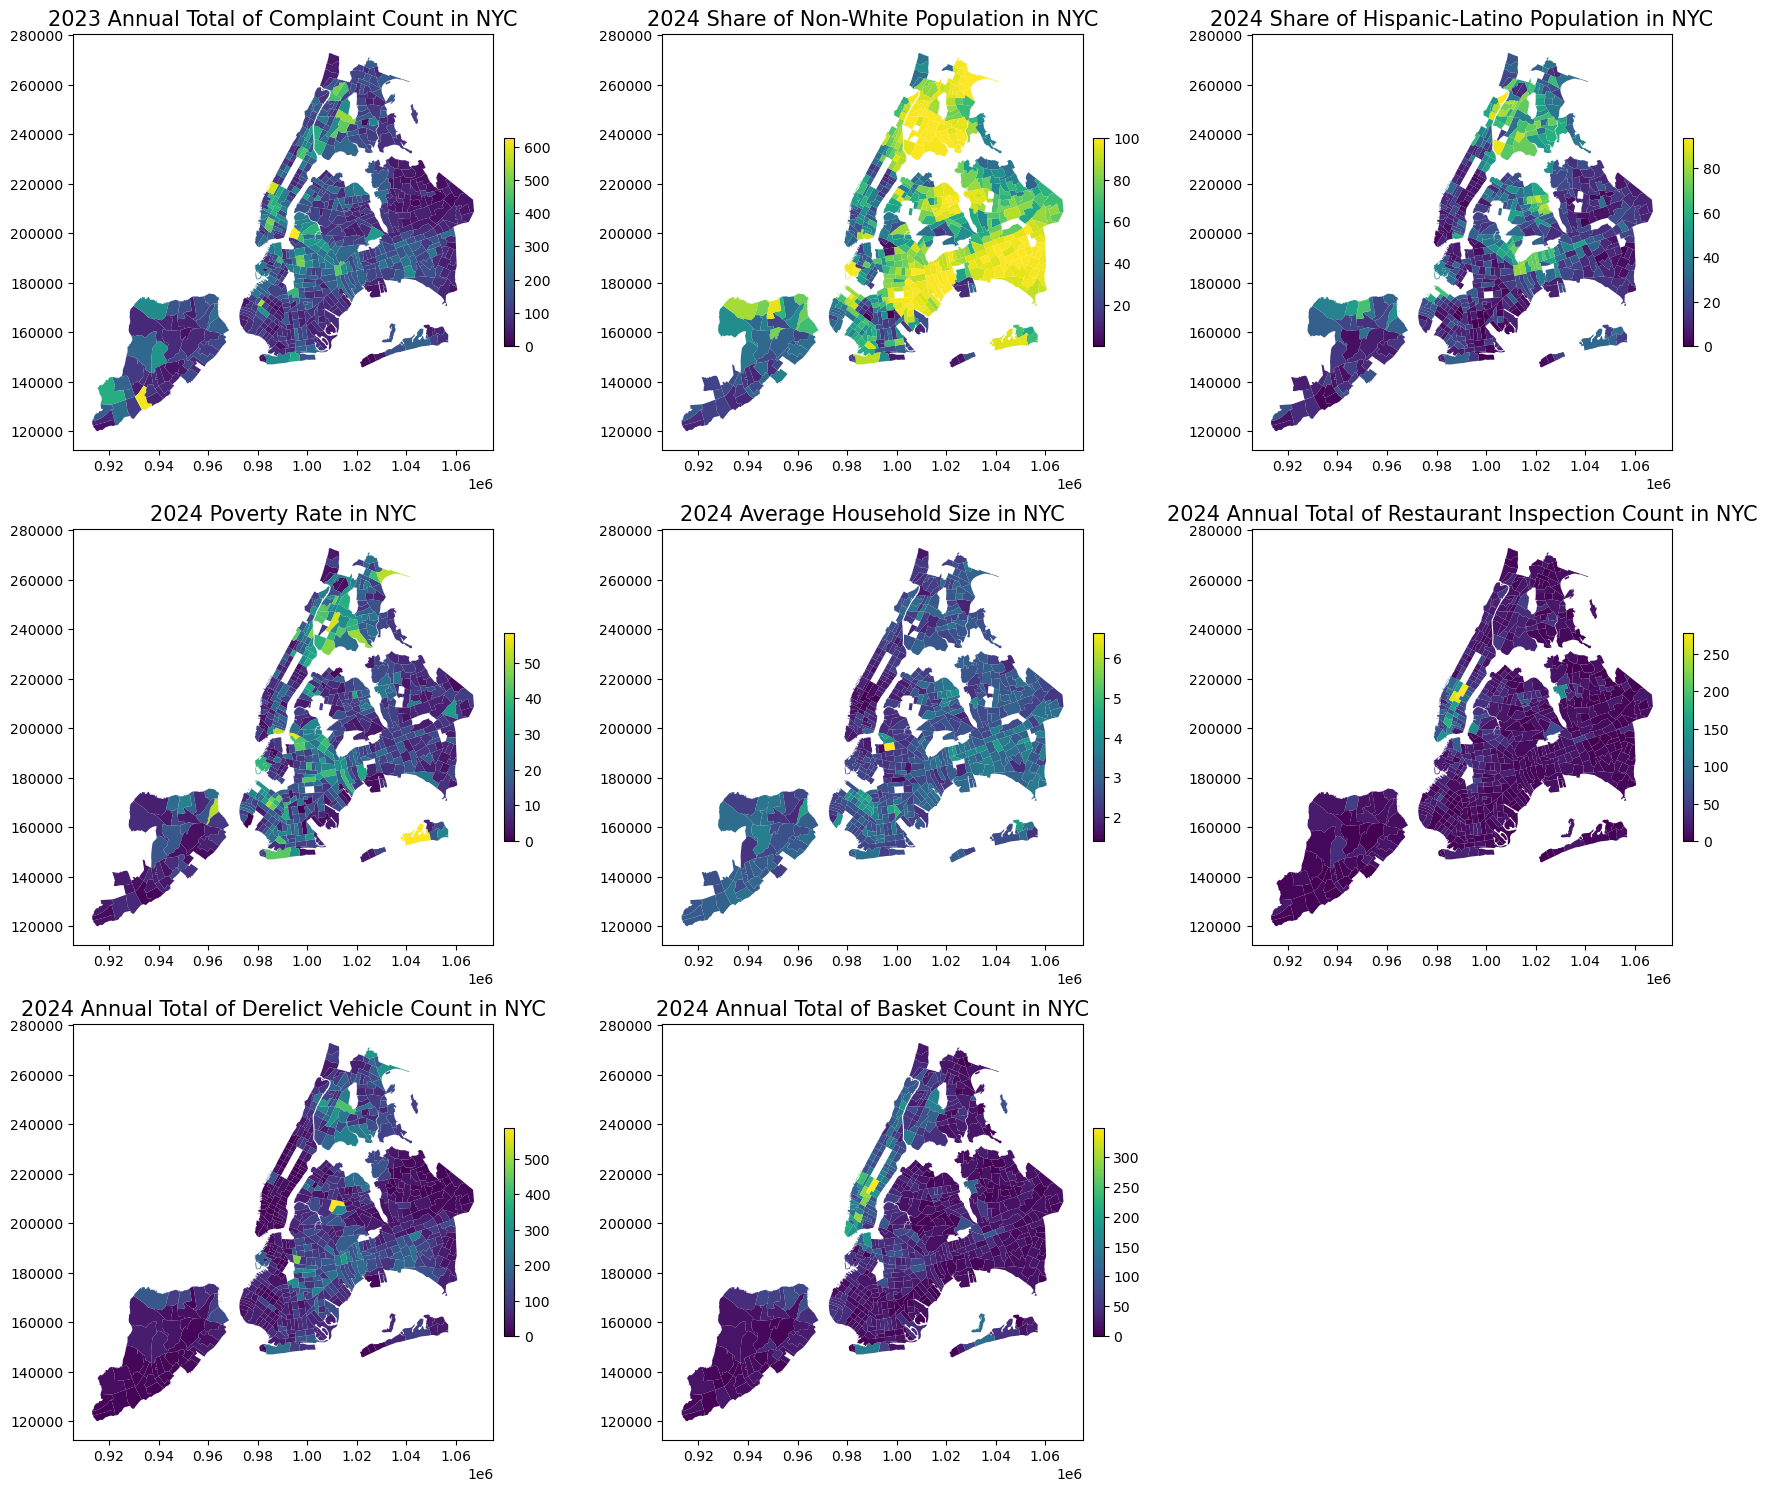

In [38]:
num_cols = 3
num_rows = -(-len(metrics) // num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows)) 

axes = axes.flatten()

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i]
    DSNY_pred_final_grouped.plot(
        column=metric, 
        cmap="viridis", 
        legend=True, 
        ax=ax,
        legend_kwds={
            'shrink': 0.5,  
            'location': 'right', 
            'pad': 0.02,
            'aspect': 20   
        }
    )
    ax.set_title(f"{metric} in NYC", fontsize=15)

# Turn off unused subplots
for j in range(len(metrics), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

## Save Data for 2024 Prediction

In [39]:
DSNY_pred_master = DSNY_pred_final.drop(columns=["geometry"])

DSNY_pred_master.to_parquet('data/4_DSNY_pred_master.parquet', index=False)